# Übungsblatt 6 - Programmieraufgaben (15 Punkte)
BA-INF 153: Einführung in Deep Learning für Visual Computing

**Deadline : 19.06.2024 - 14:00 via eCampus**

**Tutoren:**
 * Alina Pollehn - s6aapoll@uni-bonn.de
 * Johannes van de Locht - s6jovand@uni-bonn.de
 
**Übungsgruppenleitung:**
 * Jan Müller - muellerj@cs.uni-bonn.de

**Hinweis :** Wir sind endlich so weit, dass wir über alle grundlegenden Techniken verfügen um interessante Netzwerke für Computer Vision zu entwerfen, aber je Größer die Netzwerke und Datensätz werden, desto länger dauert das Training der Modelle. Planen Sie daher beim Bearbeiten der Übungsaufgaben ein, dass so nicht nur Programmieren müssen, sondern die Netzwerke auch trainiert werden müssen.

## Imports

In [11]:
from typing import Type, Tuple, List

import time
import torch
import torch.nn as nn
import torchvision
import numpy as np

from visualize import (
    show_image_grid,
    show_loss_curve,
    show_decision_boundary
    
)
torch.cuda.is_available()

True

## Laden des CIFAR-10 Datensatz

Die Library `torchvision` haben Sie als Teil von PyTorch installiert. Torchvision stellt Werkzeuge zur Vorverarbeitung von Daten sowie vortrainierte neuronale Netzwerke für Computer Vision Anwendungen bereit. Außerdem stellt Torchvision auch Datensätze zur Verfügung. Auf diesem Aufgabenblatt betrachten wir den CIFAR10 Datensatz. CIFAR10 umfasst 60.000 Bilder (32x32 RGB-Bilder) in 10 Klassen, wie Flugzeuge und Autos, mit jeweils 6.000 Bildern pro Klasse."

**Bitte führen Sie die nachfolgende Codezelle aus um den CIFAR10 Datensatz zu laden**

In [2]:
# Laden des CIFAR10 Datensatz
transforms = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.CIFAR10("./", train=True, download=True, transform = transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 128, True)

test_dataset = torchvision.datasets.CIFAR10("./", train=False, download=True, transform = transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 32, False)

Files already downloaded and verified
Files already downloaded and verified


## MLP für (multi-class) Objekt-Klassifizerung auf Cifar10 (3 Punkte)

Aufgabe:

1. (1 Punkt) Benennen Sie die Klasse `BinaryClassifier` in `MulticlassClassifierMLP` um und refaktorisieren Sie den Konstruktor und die forward -Methode so, dass das MLP einen Tensor aus Bildern entgegennehmen kann und die Ausgabedimension des MLPs der Anzahl der Klassenlabels entspricht. Achten Sie darauf, dass die Aktivierungsfunktion der Ausgabe des `MulticlassClassifierMLP` zur Zielfunktion passt.

2. (1 Punkt) Benennen Sie die Funktion `train_binary` in `train_multiclass` um und refaktorisieren Sie die Funktion so, dass das neuronale Netzwerk model mit dem Optimierer `optimizer` trainiert wird, um die Aufgabe der Mehrklassen-Objektklassifizierung auf den Daten des Dataloaders `train_loader` zu lernen. Wählen Sie dazu eine geeignete Zielfunktion.

3. (1 Punkt) Benennen Sie die Funktion `eval_binary` in `eval_multiclass` um und refaktorisieren Sie die Funktion so, dass die Genauigkeit des neuronalen Netzwerks `model` auf den Daten des Test-Dataloaders `test_loader` berechnet wird.

Hinweis: Sie können annehmen, dass die Dataloader über Tupel aus Tensoren (`images`, `labels`) iterieren. Der Tensor `images` hat die Form (n, 32, 32, 3) und den Datentyp float32. Der Tensor `labels` hat die Form (n,) und den Datentyp int64. Die Einträge im Tensor `labels` entsprechen den korrekten Klassenindizes pro Bild.

In [12]:
class MulticlassClassifierMLP(nn.Module):

    def __init__(self, layers_dims: list[int], activation_fn: Type) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        num_layers = len(layers_dims)
        
        for idx, in_dim in enumerate(layers_dims[:-1]):
            out_dim = layers_dims[idx + 1]
            linear_layer = nn.Linear(in_dim, out_dim)
            self.layers.append(linear_layer)
            if idx < num_layers - 2:
                self.layers.append(activation_fn())
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x.squeeze()

def train_multiclass(
    num_epochs   : int,
    model        : torch.nn.Module,
    optimizer    : torch.optim.Optimizer,
    train_loader : torch.utils.data.DataLoader,
    device       : torch.device
) -> list[float]:
    loss_curve = []
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)
    for _ in range(num_epochs):
        for train_points, train_labels in train_loader:
            train_points, train_labels = train_points.to(device), train_labels.to(device)
            predicted_labels = model(train_points)
            loss = loss_fn(predicted_labels, train_labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_curve.append(loss.item())
    return loss_curve

@torch.no_grad()
def eval_multiclass(
    model       : torch.nn.Module,
    test_loader : torch.utils.data.DataLoader,
    device      : torch.device
) -> tuple[float, torch.Tensor]:
    accuracy = 0.
    model.eval()
    model.to(device)
    accuracy, n_elements, batched_predictions = 0.0, 0, []
    for test_points, test_labels in test_loader:
        test_points, test_labels = test_points.to(device), test_labels.to(device)
        outputs = model(test_points)
        predictions = torch.round(torch.argmax(nn.Softmax(dim=-1)(outputs), dim=-1)).int()
        accuracy += torch.sum(predictions == test_labels).item()
        n_elements += len(test_labels)
        batched_predictions.append(predictions)
    model.train()
    return 100.0 * accuracy / n_elements, torch.cat(batched_predictions, dim=-1)

Testen Sie Ihre Implementierung: Es ist eine Genauigkeit von etwa 30% zu erwarten. 

Accuracy after training: 49.91


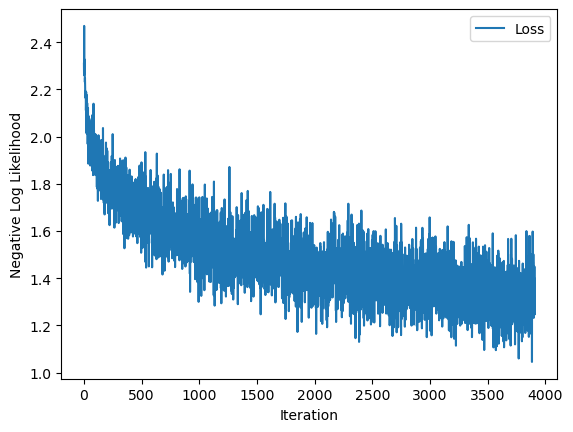

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cifar10_mlp = MulticlassClassifierMLP([32*32*3, 256, 256, 10], torch.nn.ReLU)
optim_cifar10_mlp = torch.optim.Adam(cifar10_mlp.parameters(), lr=0.001)


cifar10_mlp_loss_curve = train_multiclass(10, cifar10_mlp, optim_cifar10_mlp, train_dataloader, device)
print("Accuracy after training:", eval_multiclass(cifar10_mlp, test_dataloader, device)[0])

show_loss_curve(cifar10_mlp_loss_curve)

## MLP vs CNN für Bildklassifizierung (8 Punkte)

Eine Konvolution für 2D Daten (z.B. Bilder) kann in PyTorch mit Hilfe der Klasse:
```python
    torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding=0)
```
durchgeführt werden. Die Argumente `in_channels` und `out_channels` bestimmt die Größe der Featuredimension in der Eingabe und Ausgabe. Falls die Eingabe ein RGB Bild ist, würden wir `in_channels = 3` setzen. Das Argumente `kernel_size` kann entweder ein 2-Tuple sein, dass die Filergröße für beide Dimension festlegt oder ein Integer falls der Filter quadratisch ist. Das Argument `padding` gibt an wie viele Pixel an den Rändern hinzugefügt werden soll und kann entweder ebenfalls ein 2-Tuple/ein Integer sein oder ein String `'SAME'` bzw. `'VALID'`. Übergeben Sie `'SAME'` ist die Höhe/Breite der Ausgabe identisch zur Eingabe, anderenfalls wird kein "padding" verwendet. Weiter Details können Sie in der [Dokumentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) finden.

Ein weiteres Bauteil eines einfachen CNNs ist die Maxpooling Funktion, die in PyTorch durch die Klasse
```python
    torch.nn.MaxPool2d(kernel_size, stride=None, padding=0)
```
zur Verfügung gestellt wird. Die Argumente `kernel_size` und `padding` verhalten sich identisch zu `Conv2d`. Für das Argument `stride` können Sie einen Integer übergeben, der den Offset zwischen Filteranwendungen kontrolliert. Weiter Details können Sie in der [Dokumentation](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) finden.

In der Vorlesung haben wir mit Hilfe der Softmax Funktion, das multiclass Klassifizierungs Problem als Maximum likelihood Schätzer modelliert. In PyTorch sind zwar sowohl `Softmax` bzw. `LogSoftmax` als auch ein negative log likeihood loss `NLLLoss` vorhanden, allerdings ist es effizienter als die Zielfunktion
```python
    torch.nn.CrossEntropyLoss()
```
zu verwenden. `CrossEntropyLoss` fasst `LogSoftmax` und `NLLLoss` zusammen um die Berechnung effizienter und numerisch stabilerer durchzuführen. **Wichtig** ist allerdings, dass unser Netzwerk dann keine Aktivierungsfunktion im letzten Layer verwendet (da CrossEntropyLoss bereits Softmax integriert). Weiter Details können Sie in der [Dokumentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) finden.

**Aufgabe :**

* (2 Punkte) Vervollständigen Sie die Klasse `SimpleClassifierCNN`, so dass diese das folgende CNN zur Klassifizierung von RGB-Bildern implementiert:

\begin{equation}
   \text{Conv}_{c_\text{in} = 3, c_\text{out} = 16, k=3} \to \text{ReLU} \to \text{MaxPool}_{k=2,s=2} \to \text{Conv}_{c_\text{in} = 16, c_\text{out} = 32, k=3} \to \text{ReLU} \to \text{MaxPool}_{k=2,s=2} \to \text{Conv}_{c_\text{in} = 32, c_\text{out} = 64, k=3} \to \text{ReLU} \to \text{MaxPool}_{k=2,s=2} \to \text{Linear}_{d_{\text{in}}=1024,d_{\text{out}}=10}
\end{equation}

wobei $c_\text{in}, c_\text{out}$ die Anzahl an Input- bzw. Outputkanälen der Convolutionslayer ist, $k$ die Kernelgröße ist, $s$ der Stridefaktor ist, und  $d_{\text{in}},d_{\text{out}}$ die Ein- bzw. Ausgabedimension eines Linearen Layer sind. Das Padding aller Kerneloperationen sollte so gewählt werden, dass die Kernel auch auf Randpixel angewendet werden.

* (6 Punkte) Trainieren Sie CNN `SimpleClassifierCNN` auf dem CIFAR-10 Datensatz und vergleichen Sie anschließend das CNN `SimpleClassifierCNN` mit dem MLP `MulticlassClassifierMLP`. Beschrieben Sie die unterschiedlichen Konvergenzverhalten der Modelle anhand der Plots des Trainingsloss und vergleichen Sie die Genauigkeit der Modelle auf den Testdaten des CIFAR-10 Datensatz. Zum Vergleich von Netzwerken mit unterschiedlichen Architekturen gibt es verschiedene Herangehensweisen. Verwenden Sie **beide** der folgenden zwei Ansätze zum Vergleich des CNN und des MLPs:

   1. Wählen Sie die Anzahl der verborgenen Schichten und der Neuronen, so dass die Anzahl der Parameter des MLP (fast) gleich der Anzahl der Gewichte im CNN ist. Verwenden Sie den gleichen Optimierer und die gleichen Hyperparameter zum Training des MLPs, die Sie auch zum Training des CNNs verwendet haben.
   2. Wählen Sie die Anzahl der verborgenen Schichte und der Neuronen und sonstige Hyperparameter des MLPs so wie Sie es für richtig halten (ggf nach einigen Tests). Training Sie das MLP für die gleiche Dauer, die das Training des CNNs für 10 Epochen in Anspruch genommen hat.

Kommentieren Sie welche Vor- oder Nachteile sie in den beiden Ansätzen zum Vergleich der Modelle sehen.

In [5]:
class SimpleClassifierCNN(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_layers = torch.nn.ModuleList()
        self.conv_layers.append(torch.nn.Conv2d(3, 16, 3, padding=1))
        self.conv_layers.append(torch.nn.ReLU())
        self.conv_layers.append(torch.nn.MaxPool2d(2, 2))
        self.conv_layers.append(torch.nn.Conv2d(16, 32, 3, padding=1))
        self.conv_layers.append(torch.nn.ReLU())
        self.conv_layers.append(torch.nn.MaxPool2d(2, 2))
        self.conv_layers.append(torch.nn.Conv2d(32, 64, 3, padding=1))
        self.conv_layers.append(torch.nn.ReLU())
        self.conv_layers.append(torch.nn.MaxPool2d(2, 2))
        
        self.fc_layer = torch.nn.Linear(64 * 4 * 4, 10)  

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.conv_layers:
            x = layer(x)
        
        # Flatten the tensor before passing it to the linear layer
        x = x.view(x.size(0), -1)
        
        x = self.fc_layer(x)
        return x

def train_multiclass(
    num_epochs   : int,
    model        : torch.nn.Module,
    optimizer    : torch.optim.Optimizer,
    train_loader : torch.utils.data.DataLoader,
    device       : torch.device
) -> list[float]:
    loss_curve = []
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)
    for _ in range(num_epochs):
        for train_points, train_labels in train_loader:
            train_points, train_labels = train_points.to(device), train_labels.to(device)
            optimizer.zero_grad()
            predicted_labels = model(train_points)
            loss = loss_fn(predicted_labels, train_labels)
            loss.backward()
            optimizer.step()
            loss_curve.append(loss.item())
    return loss_curve

@torch.no_grad()
def eval_multiclass(
    model       : torch.nn.Module,
    test_loader : torch.utils.data.DataLoader,
    device      : torch.device
) -> tuple[float, torch.Tensor]:
    accuracy = 0.
    model.eval()
    model.to(device)
    accuracy, n_elements, batched_predictions = 0.0, 0, []
    for test_points, test_labels in test_loader:
        test_points, test_labels = test_points.to(device), test_labels.to(device)
        outputs = model(test_points)
        predictions = torch.argmax(nn.Softmax(dim=-1)(outputs), dim=-1).int()
        accuracy += torch.sum(predictions == test_labels).item()
        n_elements += len(test_labels)
        batched_predictions.append(predictions)
    model.train()
    return 100.0 * accuracy / n_elements, torch.cat(batched_predictions, dim=-1)

# Beispielanwendung:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Erstellen des Modells und Optimierers
cnn = SimpleClassifierCNN()
cnn_optim = torch.optim.Adam(cnn.parameters(), lr=0.001)

# Sicherstellen, dass train_dataloader und test_dataloader korrekt definiert sind
# und die CIFAR-10-Daten laden

cnn_loss_curve = train_multiclass(10, cnn, cnn_optim, train_dataloader, device)
print("Accuracy after training:", eval_multiclass(cnn, test_dataloader, device)[0])


show_loss_curve(cnn_loss_curve)


Accuracy after training: 67.61


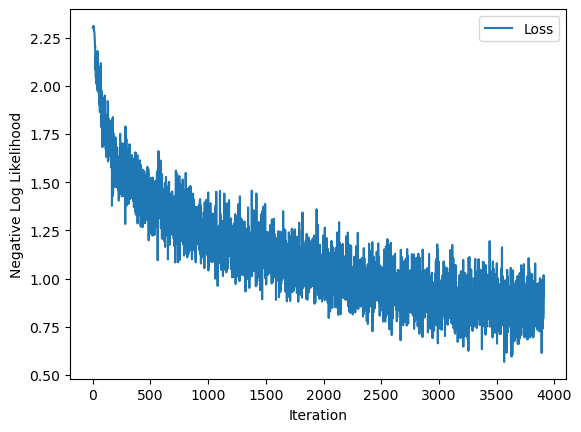

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cnn = SimpleClassifierCNN()
cnn_optim = torch.optim.Adam(cnn.parameters(), lr=0.001)

cnn_loss_curve = train_multiclass(10, cnn, cnn_optim, train_dataloader, device)
print("Accuracy after training:", eval_multiclass(cnn, test_dataloader, device)[0])


show_loss_curve(cnn_loss_curve)

In [ ]:
# Vergleichen Sie, entsprechend der Aufgabe, das MulticlassClassifierMLP mit dem CNN

Kommentar bzgl. des Vergleichs von Modellen:

Die Anzahl der Parameter festzulegen ist nur bei gleichen (oder sehr ähnlichen Architekturen) aussagekräftig, da die Kapazität (wie effizient ein Netzwerk Informationen repräsentieren kann) bei Modellen mit unterschiedlichen Architekturen (hier Fully-connected vs Conv.) sehr unterschiedlich mit Parameteranzahl korreliert. 

Das Training der Modelle für die selbe Zeitspanne, ermöglicht es individuelle (optimierte) Hyperparameter für die Modelle zu wählen. Mit dieser Methode können sehr unterschiedliche Architekturen verglichen werden und es ist deshalb die gängigste Methode zum direkten Vergleich von Modellen. Wichtig ist natürlich, dass die Test auf gleicher Hardware durchgeführt werden. Die Trainingsdauer ist hier ein Surrogate für die Rechenleistung die zum Training gebraucht wird. 

## Daten-Augmentation (4 Punkte + 4 Bonuspunkte)

Eben so wichtig wie die Architektur und Optimierungsalgorithmen sind die Daten für das erfolgreiche Training eines Neuronalen Netzwerks. Um das Netzwerk robuster zu machen, sollten die Daten augmentiert werden, d.h. es werden Transformationen auf die existierenden Daten angewendet die, die Varianz der erhöhen aber keine semantischen Veränderungen herbei führen.

**Aufgabe :** 

* *(1 Punkte)* [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html) enthält eine Vielzahl Transformationen zur Veränderung der Bilder im Trainingsdatensatz. Schauen Sie sich die Liste der verfügbaren Funktionen an und finden Sie 2-3 Transformationen, die zufällig neue Versionen von Bildern erzeugen und fassen Sie die ausgewählten Transformationen mit `torchvision.transforms.Compose` zu einer Transformation zusammen. Begründen Sie Ihre Auswahl der Transformationen.
* *(3 Punkte)* Wählen Sie ein Bild der CIFAR-10 Trainingsdaten aus, visualisieren Sie das Bild und wenden Sie die ausgewählten Transformationen 24 mal auf das Bild an. Visualisieren Sie das ursprüngliche Bild und seine augmentierten Versionen in einem 5x5 Grid wobei das Bild in der oben linken Ecke das Originalbild sein sollte. Sie können die Funktion `show_image_grid` verwenden um sich die Bilder anzeigen zu lassen.
* *(4 Bonuspunkte)*  Trainieren Sie ein CNN Ihrer Wahl auf dem CIFAR-10 Datensatz mit und ohne Augmentierung für die gleiche Dauer und zeichnen Sie Verlust und Genauigkeit nach jeder Epoche auf. Vergleichen Sie die die Modelle. 

**Hinweis :** Möglicherweise müssen Sie mit der Wahl der Parameter für die Daten-Transformationen experimentieren.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

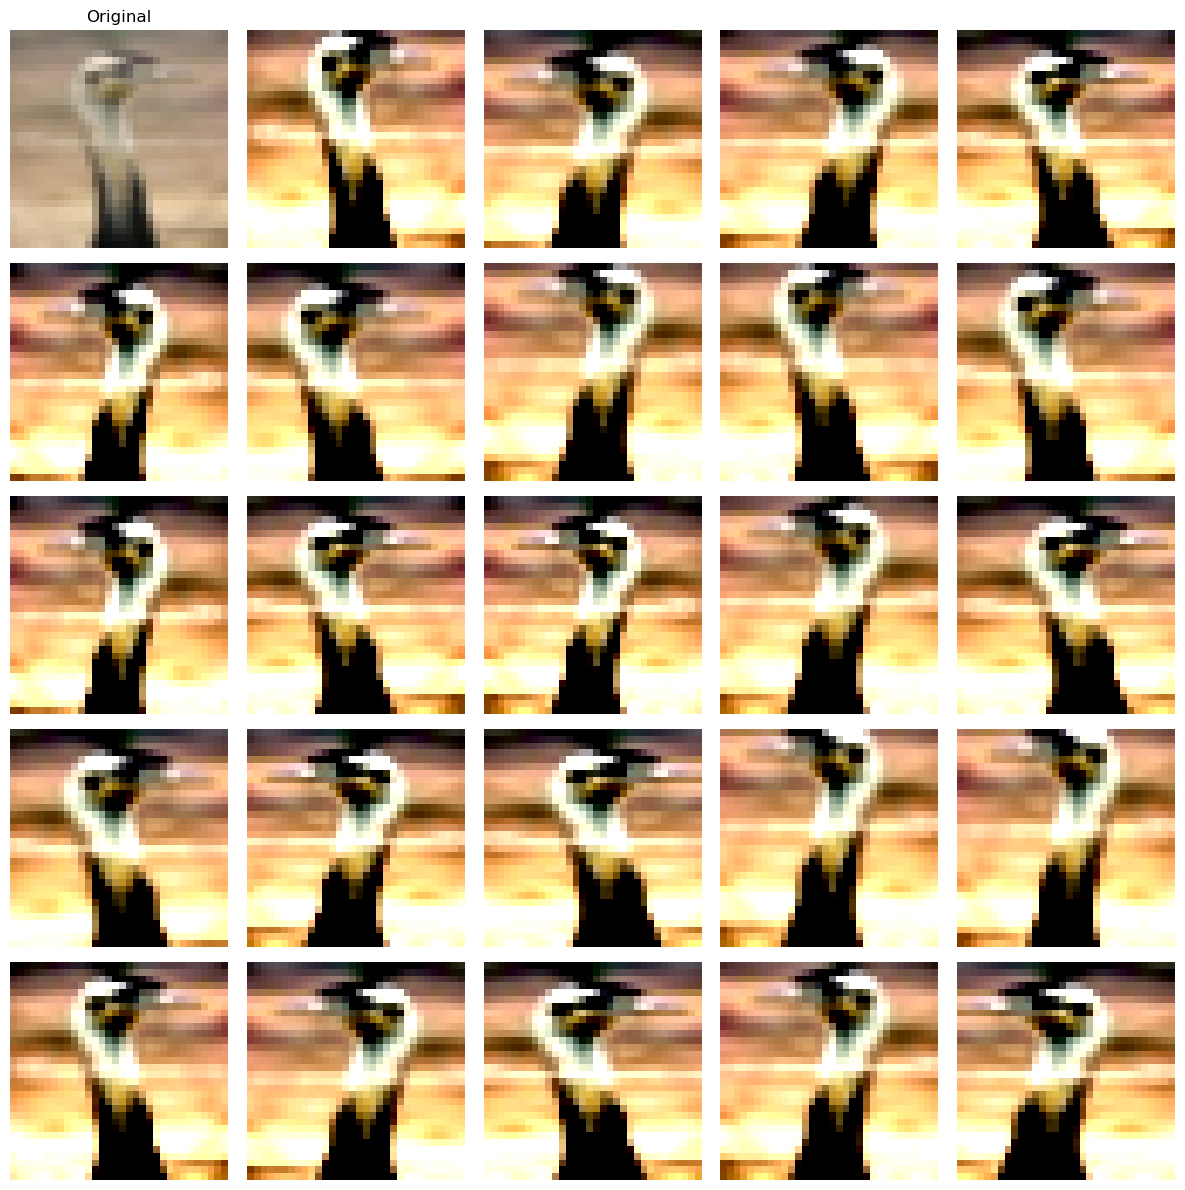

In [27]:
import matplotlib.pyplot as plt
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ein Bild aus dem CIFAR-10 Trainingsdatensatz auswählen
image, label = next(iter(train_dataloader))
image = image[0]  # Nur das erste Bild im Batch nehmen

def show_image_grid(image, transformations, n=24):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    for i, ax in enumerate(axes.flatten()):
        if i == 0:
            ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
            ax.set_title("Original")
        else:
            transformed_image = transformations(image)
            ax.imshow(np.transpose(transformed_image.numpy(), (1, 2, 0)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_image_grid(image, data_transforms)


Es wird Random Resize Corp genommen, um das Modell robust gegenüber unterschiedlichen Bildgrößen zu machen. Random Horizontal Flip wird genommen, um das Modell robuster gegenüber verschiedenen Perspektiven zu machen Normalize wird genommen, um die Pixelwerte zu normalisieren und somit besser trainierbar zu machen.

In [ ]:
# Bonus: Vergleichen Sie die Trainingergebnisse eines CNN, das trainiert wurde mit und ohne augmentierten Bildern.